In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import root
from scipy.optimize import fsolve

Constants

In [10]:
a_v = 15.71511  # MeV
a_s = 17.53638  # MeV
a_c = 0.71363   # MeV
a_a = 23.37837  # MeV

C_l = 3.40665e-3  # Lattice constant

m_n = 939.565   # MeV, neutron mass
m_p = 938.272   # MeV, proton mass
dm = m_n - m_p

m = 939         # MeV, mean baryon mass
g_cm3_to_MeV4 = 4.24742944e-6  # units conversion
rho_drip = 4e11  # g/cm3 density drip point

Liquid-drop formula

Calculating optimal x, y using only the nuclear energy $ε_n(x, y)$

In [11]:
# System of equations
def equations(p):
    x, y = p
    eq1 = -a_s / (x**2) + 2 * a_c * x * y**2              # (6ε/6x)_y = 0
    eq2 = -dm + 2 * a_c * x**2 * y - 4 * a_a * (1 - 2*y)  # (6ε/6y)_x = 0
    return [eq1, eq2]

initial_guess = [4.0, 0.5]  # x ~ A^(1/3), y ~ Z/A

x_sol, y_sol = fsolve(equations, initial_guess)

A0 = x_sol ** 3
Z0 = y_sol * A0

print(f"x0 = {x_sol:.5f}")
print(f"y0 = {y_sol:.5f}")
print(f"A0 = {A0:.4f}")
print(f"Z0 = {Z0:.4f}")

x0 = 3.90612
y0 = 0.45405
A0 = 59.5988
Z0 = 27.0606


Exact solution: Including electronic and Lattice contribution

In [12]:
def equations_with_lattice(p, pF):
    x, y = p
    a_c_renorm = a_c - C_l * pF  # renormalized a_c (with Lattice)
    eq1 = -a_s / (x**2) + 2 * a_c_renorm * x * y**2                              # (6ε/6x)_y = 0
    eq2 = -dm + 2 * a_c_renorm * x**2 * y - 4 * a_a * (1 - 2*y) + y**(1/3) * pF  # (6ε/6y)_x = 0
    return [eq1, eq2]

def equations_no_lattice(p, pF):
    x, y = p
    a_c_renorm = a_c  # without Lattice, a_c(pF) = a_c
    eq1 = -a_s / (x**2) + 2 * a_c_renorm * x * y**2                              # (6ε/6x)_y = 0
    eq2 = -dm + 2 * a_c_renorm * x**2 * y - 4 * a_a * (1 - 2*y) + y**(1/3) * pF  # (6ε/6y)_x = 0
    return [eq1, eq2]

pF_range = np.linspace(0.1, 40, 100)  # MeV

initial_guess = [4.0, 0.5]  # x ~ A^(1/3), y ~ Z/A

results_with = {'x': [], 'y': [], 'A': [], 'Z': []}
results_no = {'x': [], 'y': [], 'A': [], 'Z': []}

for pF in pF_range:
    # with Lattice
    x_sol, y_sol = fsolve(equations_with_lattice, initial_guess, args=(pF,))
    results_with['x'].append(x_sol)
    results_with['y'].append(y_sol)
    results_with['A'].append(x_sol**3)
    results_with['Z'].append(y_sol * x_sol**3)
    
    # without Lattice
    x_sol, y_sol = fsolve(equations_no_lattice, initial_guess, args=(pF,))
    results_no['x'].append(x_sol)
    results_no['y'].append(y_sol)
    results_no['A'].append(x_sol**3)
    results_no['Z'].append(y_sol * x_sol**3)

Linear approximation

In [13]:
def linear_approx(p_F):
    x0 = 3.90612
    y0 = 0.45405
    C1 = 4*a_a / (x0**2 * a_c)
    C2 = 1 / (2 * x0**2 * y0**(2/3))
    xi = ((C1 - 1)*C_l + 2*C2) / (3*C1 - 1) * (p_F/a_c)
    eta = - (3*C2 - C_l) / (3*C1 - 1) * (p_F/a_c)
    return x0*(1 + xi), y0*(1 + eta)

x_linear, y_linear = linear_approx(pF_range)

Generating graph

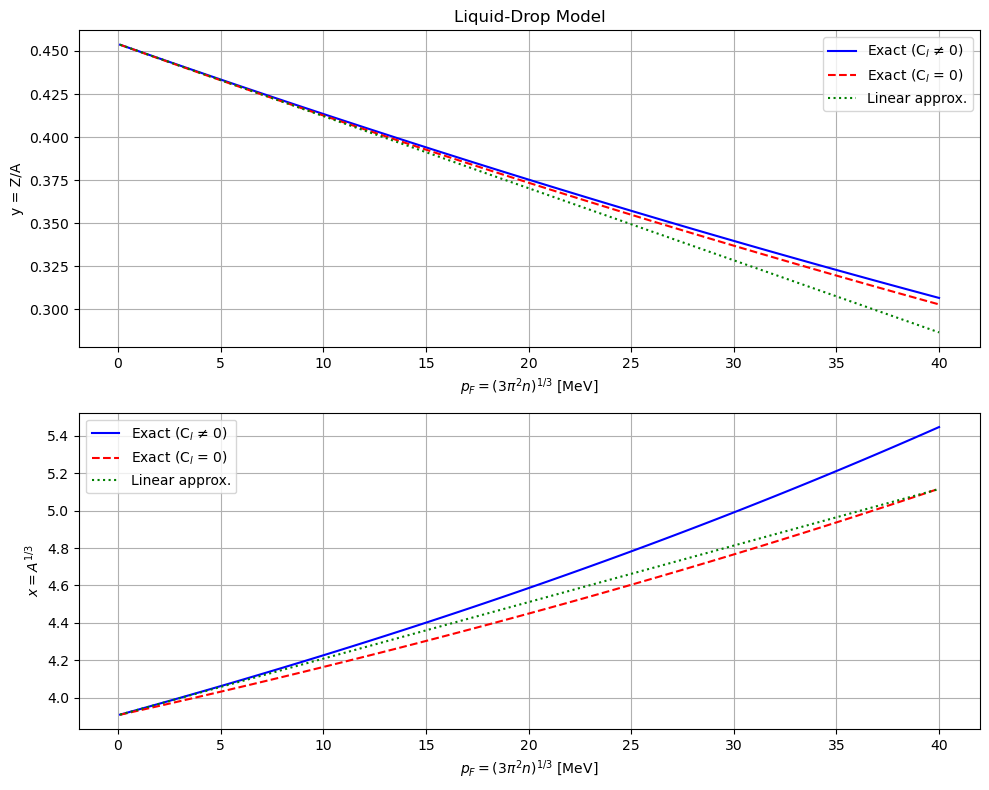

In [14]:
plt.figure(figsize=(10, 8))

# plot: y vs pF
plt.subplot(2, 1, 1)
plt.plot(pF_range, results_with['y'], label='Exact (C$_{l}$ ≠ 0)', color='blue')
plt.plot(pF_range, results_no['y'], label='Exact (C$_{l}$ = 0)', color='red', linestyle='--')
plt.plot(pF_range, y_linear, label='Linear approx.', color='green', linestyle=':')
plt.xlabel('$p_F=(3π^2n)^{1/3}$ [MeV]')
plt.ylabel('y = Z/A')
plt.legend()
plt.grid(True)
plt.title('Liquid-Drop Model')

# Κάτω plot: x vs pF
plt.subplot(2, 1, 2)
plt.plot(pF_range, results_with['x'], label='Exact (C$_{l}$ ≠ 0)', color='blue')
plt.plot(pF_range, results_no['x'], label='Exact (C$_{l}$ = 0)', color='red', linestyle='--')
plt.plot(pF_range, x_linear, label='Linear approx.', color='green', linestyle=':')
plt.xlabel('$p_F=(3π^2n)^{1/3}$ [MeV]')
plt.ylabel('$x = A^{1/3}$')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('liquid_drop_model.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Densities' range
rho_gcm3 = np.logspace(6, 11.5, 2000)  # 10^6 to 5e11 g/cm³
rho_MeV4 = rho_gcm3 * g_cm3_to_MeV4

# Calculating n and p_F
n = rho_MeV4 / m
pfermi = (3 * np.pi**2 * n)**(1/3)

# Συνάρτηση για εύρεση βέλτιστων (x, y)
resfinal = []
for pf in pfermi:
    x,y = fsolve(equations_with_lattice,(3,3),args=(pf))
    A = int(x**3)
    Z = int(A*y) 
    N = A-Z
    resfinal.append({'pF': pf, 'A': A, 'Z': Z, 'N': N})

# DataFrame
dffinal = pd.DataFrame(resfinal)
dffinal

,pF,A,Z,N
0,0.511635,60,27,33
1,0.512717,60,27,33
2,0.513801,60,27,33
3,0.514887,60,27,33
4,0.515975,60,27,33
...,...,...,...,...
1995,34.564108,139,45,94
1996,34.637177,140,45,95
1997,34.710399,140,45,95
1998,34.783777,140,45,95


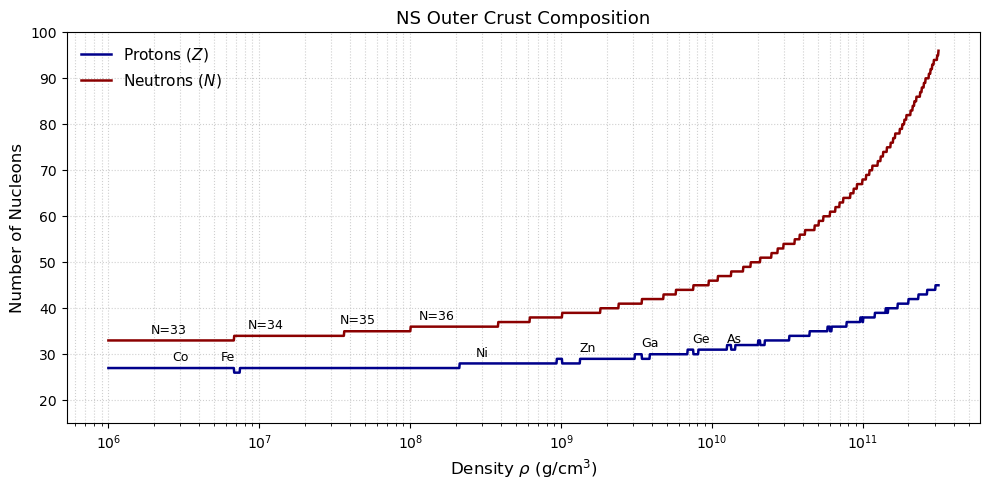

In [16]:
# Generating plot
plt.figure(figsize=(10, 5), dpi=100)

plt.plot(rho_gcm3, dffinal['Z'], label=r'Protons ($Z$)', color='darkblue', linewidth=1.8)
plt.plot(rho_gcm3, dffinal['N'], label=r'Neutrons ($N$)', color='darkred', linewidth=1.8, linestyle='-')

plt.xscale('log')
plt.ylim([15, 100])

plt.xlabel(r'Density $\rho$ (g/cm$^3$)', fontsize=12)
plt.ylabel('Number of Nucleons', fontsize=12)
plt.title('NS Outer Crust Composition', fontsize=13)

plt.legend(loc='best', fontsize=11, frameon=False)
plt.grid(True, which='both', linestyle=':', linewidth=0.8, alpha=0.6)

# --- Labels over Z (Protons) ---
labels_Z = {
    3e6: 'Co', 6.2e6: 'Fe', 3e8: 'Ni', 1.5e9: 'Zn',
    3.9e9: 'Ga', 8.4e9: 'Ge', 1.4e10: 'As'
}
for xval, symbol in labels_Z.items():
    idx = (abs(rho_gcm3 - xval)).argmin()
    yval = dffinal['Z'].iloc[idx]
    plt.text(xval, yval + 1.5, symbol, fontsize=9, ha='center', color='black')

# --- Labels over N (Neutrons) ---
labels_N = {
    2.5e6: 'N=33', 1.1e7: 'N=34', 4.5e7: 'N=35', 1.5e8: 'N=36'
}
for xval, label in labels_N.items():
    idx = (abs(rho_gcm3 - xval)).argmin()
    yval = dffinal['N'].iloc[idx]
    plt.text(xval, yval + 1.5, label, fontsize=9, ha='center', color='black')

plt.tight_layout()
plt.savefig('outer_crust_comp.png', dpi=300, bbox_inches='tight')
plt.show()